# Feature selection for detection
Regression has to be done by ion (mol+adduct), because we don't have a good way to combine intensities across adducts.

In [44]:
from pathlib import Path
import scipy.stats
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
plt.style.use('dark_background')



In [55]:
TASK_TYPE = "regression_on_detected"
# TASK_TYPE = "detection_per_mol"

In [59]:
results_dir = Path.cwd() / "../results" / TASK_TYPE
plots_dir = Path.cwd() / "../plots" / TASK_TYPE
plots_dir.mkdir(exist_ok=True, parents=True)

filenames = {
    "fingerprints": "fingerprints_feat_selection_results.csv",
    # "mol": "mol_feat_selection.csv",
    # "random_feat": "regr_results_random_feat.csv",
    # "no_feat": "regr_results_no_feat.csv",
}

if "detection" in TASK_TYPE:
    INCLUDE_NOT_DETECTED_IN_SCORE = None
elif "regression" in TASK_TYPE:
    INCLUDE_NOT_DETECTED_IN_SCORE = False


In [60]:
# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
if "detection" in TASK_TYPE:
    score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                                                'det_precision', 'det_recall', 'det_f1', 'detected', 'macro_avg_f1_score']
    model_metrics = pd.DataFrame(columns = ['train_setup', 'matrix', 'polarity', 'model_type', 'feat_sel_method', 'quantile', 'nb_features'] + score_cols)
    model_metrics_global = pd.DataFrame(columns = ['train_setup', 'model_type', 'feat_sel_method', 'quantile', 'nb_features'] + score_cols)
    model_typename = "classifier"
elif "regression" in TASK_TYPE:
    # compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
    scores = ["Spearman's R", 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs']
    model_metrics = pd.DataFrame(columns = ['train_setup', 'matrix', 'polarity', 'model_type', 'feat_sel_method', 'quantile', "nb_features"] + scores)
    model_metrics_global = pd.DataFrame(columns = ['train_setup', 'model_type', 'feat_sel_method', 'quantile', "nb_features"] + scores)
    model_typename = "regressor"


models_results = pd.DataFrame()
counter = 0
counter_global = 0

for train_setup in filenames:
    result_filename = filenames[train_setup]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col = 0)
    loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                          'Polarity': 'polarity'})

    if loc_models_results.observed_value.dtype == "bool":
        loc_models_results.observed_value = np.where(loc_models_results.observed_value, 1, 0)



    for (matrix, polarity, model_type, feat_sel_met, quantile), rows in loc_models_results.groupby(['matrix', 'polarity', model_typename, 'feat_sel_method', 'feat_sel_quantile']):
        # remove zero intensity molecules if needed (optional)

        if "detection" in TASK_TYPE:
            clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
            if rows.observed_value.max() == 0:
                print("no detection!")
            result_row = [train_setup, matrix, polarity, model_type, feat_sel_met, round(quantile*6), rows["nb_features"].drop_duplicates()[0],
                                              clf_report['0']['precision'], clf_report['0']['recall'],
                                              clf_report['0']['f1-score'], clf_report['0']['support'],
                                              clf_report['1']['precision'], clf_report['1']['recall'],
                                              clf_report['1']['f1-score'], clf_report['1']['support'],
                                              clf_report['macro avg']['f1-score']
                                              ]
            model_metrics.loc[counter] = result_row
        elif "regression" in TASK_TYPE:
            if not INCLUDE_NOT_DETECTED_IN_SCORE:
                rows = rows[rows['observed_value']!=0]

            spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
            pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
            mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
            mse_std = mse / rows['observed_value'].std()
            model_metrics.loc[counter] = [train_setup, matrix, polarity, model_type, feat_sel_met, round(quantile*6), rows["nb_features"].drop_duplicates()[0],
                                          spearman[0], spearman[1],
                                               pearson[0], pearson[1], mse, mse_std,
                                               rows[rows['observed_value']!=0].shape[0]]

        counter += 1

    loc_models_results["train_setup"] = train_setup
    models_results = pd.concat([models_results, loc_models_results])

    # Compute global scores:
    for (model_type, feat_sel_met, quantile), rows in loc_models_results.groupby([model_typename, 'feat_sel_method', 'feat_sel_quantile']):
        if "detection" in TASK_TYPE:
            clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
            if rows.observed_value.max() == 0:
                print("no detection!")
            model_metrics_global.loc[counter_global] = [train_setup, model_type, feat_sel_met, round(quantile*6), rows["nb_features"].drop_duplicates()[0],
                                              clf_report['0']['precision'], clf_report['0']['recall'],
                                              clf_report['0']['f1-score'], clf_report['0']['support'],
                                              clf_report['1']['precision'], clf_report['1']['recall'],
                                              clf_report['1']['f1-score'], clf_report['1']['support'],
                                              clf_report['macro avg']['f1-score']
                                              ]
        elif "regression" in TASK_TYPE:
            if not INCLUDE_NOT_DETECTED_IN_SCORE:
                rows = rows[rows['observed_value']!=0]

            spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
            pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
            mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
            mse_std = mse / rows['observed_value'].std()
            model_metrics_global.loc[counter_global] = [train_setup, model_type, feat_sel_met, round(quantile*6), rows["nb_features"].drop_duplicates()[0], spearman[0], spearman[1],
                                               pearson[0], pearson[1], mse, mse_std,
                                               rows[rows['observed_value']!=0].shape[0]]

        counter_global += 1




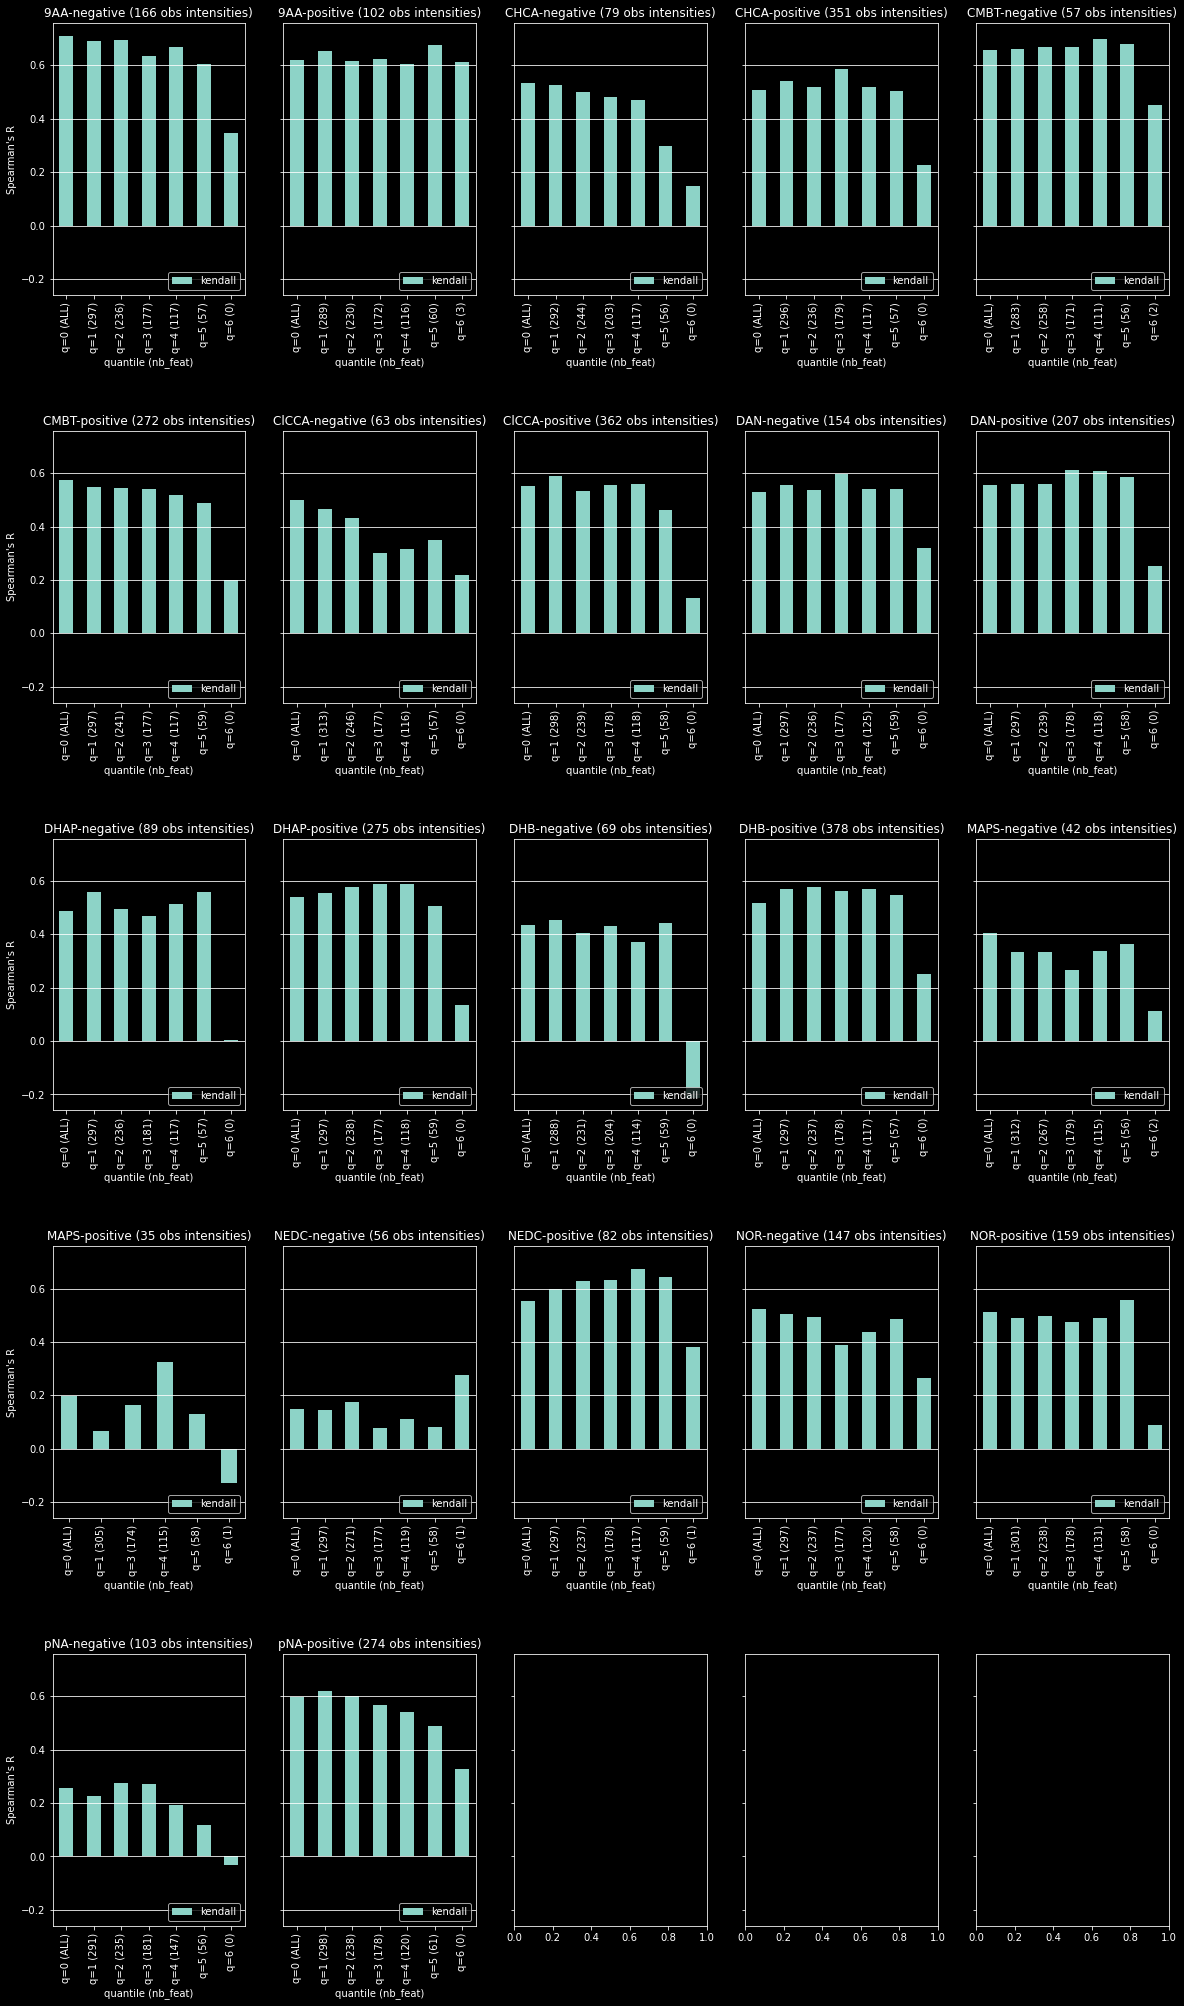

In [61]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

feature_sel_method = "kendall"
# feature_sel_method = "mutual_info"
# feature_sel_method = "spearman"

if "detection" in TASK_TYPE:
    metric = "macro_avg_f1_score"
elif "regression" in TASK_TYPE:
    metric = "Spearman's R"


plotted_metrics = model_metrics[model_metrics.feat_sel_method == feature_sel_method]
i = 0
for (matrix, polarity), rows in plotted_metrics.groupby(['matrix', 'polarity']):
    # nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
    if "detection" in TASK_TYPE:
        count_key = 'detected'
    elif "regression" in TASK_TYPE:
        count_key = 'non-zero obs'
    nb_obs = rows[count_key].drop_duplicates().values[0]
    rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
    rows["quantile (nb_feat)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
    rows = rows.set_index(["quantile (nb_feat)", "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
    rows = rows.unstack("feat_sel_method")
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs} obs intensities)")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    # TODO: position legend
    ax_list[i].legend(loc="lower right")
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)
    i+=1

plt.subplots_adjust(hspace=0.5)
plt.show()
(plots_dir / "feat_selection").mkdir(exist_ok=True)
fig.savefig(plots_dir / "feat_selection"/ f"{feature_sel_method}-{INCLUDE_NOT_DETECTED_IN_SCORE}.pdf")


/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_13846/3526851019.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_13846/3526851019.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows["Quantile (Number of used fingerprint features)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"


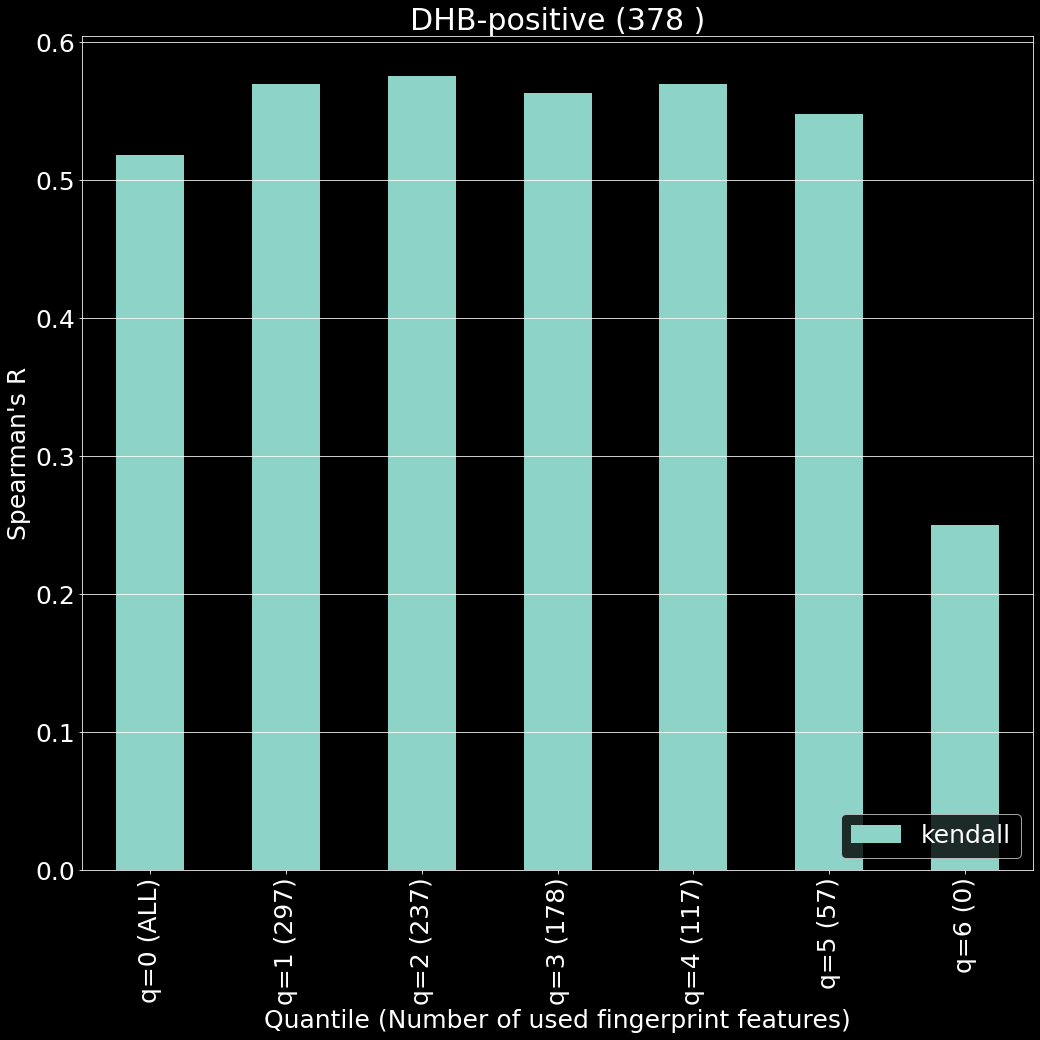

In [62]:
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (15, 15))


rows = model_metrics[(model_metrics.feat_sel_method == feature_sel_method) &
                                (model_metrics.matrix == "DHB") & (model_metrics.polarity == "positive")]
if "detection" in TASK_TYPE:
    count_key = 'detected'
elif "regression" in TASK_TYPE:
    count_key = 'non-zero obs'
nb_obs = rows[count_key].drop_duplicates().values[0]
rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
rows["Quantile (Number of used fingerprint features)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
rows = rows.set_index(["Quantile (Number of used fingerprint features)", "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
rows = rows.unstack("feat_sel_method")
rows[metric].plot.bar(ax = ax, title=f"DHB-positive ({nb_obs} )")
ax.set_ylabel(metric)
ax.grid(axis='y')
# TODO: position legend
ax.legend(loc="lower right")
# if i != 0:
#     ax_list[i].get_legend().set_visible(False)

# plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()
(plots_dir / "feat_selection").mkdir(exist_ok=True)
fig.savefig(plots_dir / "feat_selection"/ f"{feature_sel_method}-{INCLUDE_NOT_DETECTED_IN_SCORE}-DHB-positive.pdf")

<AxesSubplot:xlabel='quantile'>

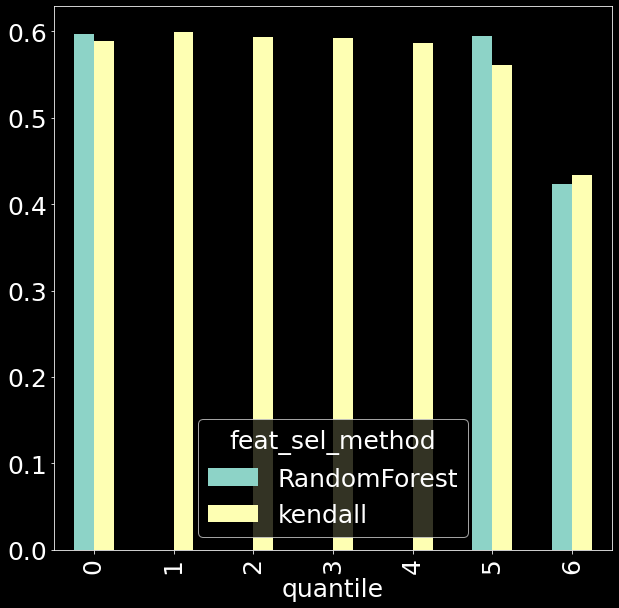

In [63]:
model_metrics_global.set_index(['quantile', "feat_sel_method"], drop=True)[metric].unstack("feat_sel_method").plot.bar(figsize=(10,10))